#BA820 Project M2 — Alone (TV Show)
* Team: A1_08
* Datasets used: `survivalists.csv`, `loadouts.csv`, `episodes.csv`
* Goal: Conduct preliminary exploratory analysis to understand the data, surface patterns/anomalies, and motivate domain/business questions for unsupervised exploration.

##Data Overview, Standardization, and Quality Assessment(Copy of M1 for consistency)


We focus on three tables that directly support individual-level behavior, strategic decision-making, and audience engagement:

* `survivalists.csv`: participant demographics and outcomes (days lasted, exit reason, medical evacuation)

* `loadouts.csv`: each survivalist’s 10-item selection, reflecting strategy under constraint

* `episodes.csv`: episode-level engagement metrics (viewers, IMDb rating)

Season-level environmental data (`seasons.csv`) was reviewed but not used in the primary exploratory analysis due to its limited sample size and largely contextual role relative to individual-level behavior and episode-level engagement.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
BASE_URL = "https://raw.githubusercontent.com/Marcusshi/BA820-A1-08/main/data/alone_tv_show/"

urls = {
    "survivalists": BASE_URL + "survivalists.csv",
    "loadouts": BASE_URL + "loadouts.csv",
    "episodes": BASE_URL + "episodes.csv"
}

In [3]:
survivalists = pd.read_csv(urls["survivalists"])
loadouts = pd.read_csv(urls["loadouts"])
episodes = pd.read_csv(urls["episodes"])

In [4]:
print("Survivalists:", survivalists.shape)
print("Loadouts:", loadouts.shape)
print("Episodes:", episodes.shape)

Survivalists: (94, 16)
Loadouts: (940, 6)
Episodes: (98, 11)


In [5]:
survivalists.head()

,season,name,age,gender,city,state,country,result,days_lasted,medically_evacuated,reason_tapped_out,reason_category,team,day_linked_up,profession,url
0,1,Alan Kay,40,Male,Blairsville,Georgia,United States,1,56,False,NaN,NaN,NaN,NaN,Corrections Officer,alan-kay
1,1,Sam Larson,22,Male,Lincoln,Nebraska,United States,2,55,False,Lost the mind game,Family / personal,NaN,NaN,Outdoor Gear Retailer,sam-larson
2,1,Mitch Mitchell,34,Male,Bellingham,Massachusetts,United States,3,43,False,Realized he should actually be around for his ...,Family / personal,NaN,NaN,Butcher,mitch-mitchell
3,1,Lucas Miller,32,Male,Quasqueton,Iowa,United States,4,39,False,Felt content with what he had done,Family / personal,NaN,NaN,Survivalist and Wildlife Therapist/Natural Hea...,lucas-miller
4,1,Dustin Feher,37,Male,Pittsburgh,Pennsylvania,United States,5,8,False,Fear of storm,Family / personal,NaN,NaN,Carpenter,dustin-feher


In [6]:
loadouts.head()

,version,season,name,item_number,item_detailed,item
0,US,1,Alan Kay,1,Saw,Saw
1,US,1,Alan Kay,2,Axe,Axe
2,US,1,Alan Kay,3,Sleeping bag,Sleeping bag
3,US,1,Alan Kay,4,Large 2-quart pot,Pot
4,US,1,Alan Kay,5,Ferro rod,Ferro rod


In [7]:
episodes.head()

,version,season,episode_number_overall,episode,title,air_date,viewers,quote,author,imdb_rating,n_ratings
0,US,1,1,1,And So It Begins,2015-06-18,1.582,I went to the woods because I wished to live d...,Henry David Thoreau,7.5,135.0
1,US,1,2,2,Of Wolf and Man,2015-06-25,1.697,If you live among wolves you have to act like ...,Nikita Khrushchev,7.7,110.0
2,US,1,3,3,The Talons of Fear,2015-07-02,1.864,Extinction is the rule. Survival is the except...,Carl Sagan,7.7,104.0
3,US,1,4,4,Stalked,2015-07-09,2.082,"Hunger, love, pain, fear are some of those inn...",Albert Einstein,7.7,104.0
4,US,1,5,5,Winds of Hell,2015-07-16,2.082,"The strong survive, but the courageous triumph.",Michael Scott,7.6,99.0


###Datasets info

In [8]:
import io
from IPython.display import display, HTML

def df_info_to_str(df):
    buffer = io.StringIO()
    df.info(buf=buffer)
    return buffer.getvalue()

In [9]:
surv_info = df_info_to_str(survivalists)
load_info = df_info_to_str(loadouts)
epis_info = df_info_to_str(episodes)

In [10]:
html = f"""
<div style="display:flex; gap:20px; font-family:monospace; font-size:12px;">
  <div style="flex:1;">
    <h4>survivalists.csv</h4>
    <pre>{surv_info}</pre>
  </div>
  <div style="flex:1;">
    <h4>loadouts.csv</h4>
    <pre>{load_info}</pre>
  </div>
  <div style="flex:1;">
    <h4>seasons.csv</h4>
    <pre>{epis_info}</pre>
  </div>
</div>
"""

display(HTML(html))

### Data Standardization and Initial Data Quality Check

We first standardize column names across all datasets by converting them to lowercase and replacing spaces or hyphens with underscores. This ensures consistent naming conventions and simplifies downstream merging and analysis.

Next, we conduct a quick data quality check for each dataset, examining:
- Dataset shape (number of rows and columns),
- Data types of each variable,
- Presence of duplicate rows.

This step helps us understand the structure and completeness of the data, identify variables with substantial missingness, and confirm that no duplicated records are present before proceeding with exploratory analysis.

###Missing Data Notes
* Missing values in the survivalists dataset are largely structural rather than indicative of data quality issues. Exit-related fields (reason_tapped_out, reason_category) are missing only for winners, for whom these variables are not applicable. Team-related fields contain missing values for most observations because the team format was exclusive to Season 4. No imputation was performed, as these missing values carry substantive meaning.  
* We also convert air_date to a datetime format to enable episode-level temporal trend analysis.

In [11]:
def clean_cols(df):
    df.columns = (
        df.columns.str.strip()
                 .str.lower()
                 .str.replace(" ", "_")
                 .str.replace("-", "_")
    )
    return df

survivalists = clean_cols(survivalists)
loadouts     = clean_cols(loadouts)
episodes     = clean_cols(episodes)

def df_check(df, name):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("dtypes:\n", df.dtypes)
    miss = (df.isna().mean().sort_values(ascending=False) * 100).round(1)
    print("\nmissing % (top):\n", miss.head(12))
    print("\nduplicated rows:", df.duplicated().sum())
    display(df.head(3))

df_check(survivalists, "survivalists")
df_check(loadouts, "loadouts")
df_check(episodes, "episodes")


=== survivalists ===
shape: (94, 16)
dtypes:
 season                   int64
name                    object
age                      int64
gender                  object
city                    object
state                   object
country                 object
result                   int64
days_lasted              int64
medically_evacuated       bool
reason_tapped_out       object
reason_category         object
team                    object
day_linked_up          float64
profession              object
url                     object
dtype: object

missing % (top):
 day_linked_up        91.5
team                 85.1
reason_tapped_out    10.6
reason_category      10.6
state                 1.1
season                0.0
age                   0.0
name                  0.0
result                0.0
country               0.0
city                  0.0
gender                0.0
dtype: float64

duplicated rows: 0


,season,name,age,gender,city,state,country,result,days_lasted,medically_evacuated,reason_tapped_out,reason_category,team,day_linked_up,profession,url
0,1,Alan Kay,40,Male,Blairsville,Georgia,United States,1,56,False,NaN,NaN,NaN,NaN,Corrections Officer,alan-kay
1,1,Sam Larson,22,Male,Lincoln,Nebraska,United States,2,55,False,Lost the mind game,Family / personal,NaN,NaN,Outdoor Gear Retailer,sam-larson
2,1,Mitch Mitchell,34,Male,Bellingham,Massachusetts,United States,3,43,False,Realized he should actually be around for his ...,Family / personal,NaN,NaN,Butcher,mitch-mitchell



=== loadouts ===
shape: (940, 6)
dtypes:
 version          object
season            int64
name             object
item_number       int64
item_detailed    object
item             object
dtype: object

missing % (top):
 version          0.0
season           0.0
name             0.0
item_number      0.0
item_detailed    0.0
item             0.0
dtype: float64

duplicated rows: 0


,version,season,name,item_number,item_detailed,item
0,US,1,Alan Kay,1,Saw,Saw
1,US,1,Alan Kay,2,Axe,Axe
2,US,1,Alan Kay,3,Sleeping bag,Sleeping bag



=== episodes ===
shape: (98, 11)
dtypes:
 version                    object
season                      int64
episode_number_overall      int64
episode                     int64
title                      object
air_date                   object
viewers                   float64
quote                      object
author                     object
imdb_rating               float64
n_ratings                 float64
dtype: object

missing % (top):
 viewers                   15.3
n_ratings                  5.1
imdb_rating                5.1
episode_number_overall     0.0
season                     0.0
version                    0.0
episode                    0.0
air_date                   0.0
title                      0.0
author                     0.0
quote                      0.0
dtype: float64

duplicated rows: 0


,version,season,episode_number_overall,episode,title,air_date,viewers,quote,author,imdb_rating,n_ratings
0,US,1,1,1,And So It Begins,2015-06-18,1.582,I went to the woods because I wished to live d...,Henry David Thoreau,7.5,135.0
1,US,1,2,2,Of Wolf and Man,2015-06-25,1.697,If you live among wolves you have to act like ...,Nikita Khrushchev,7.7,110.0
2,US,1,3,3,The Talons of Fear,2015-07-02,1.864,Extinction is the rule. Survival is the except...,Carl Sagan,7.7,104.0


In [12]:
#converting air_date to a datetime format to enable episode-level temporal trend analysis.
episodes["air_date"] = pd.to_datetime(episodes["air_date"], errors="coerce")

#EDA & Preprocessing

##Preprocessing

In [13]:
loadouts["item"] = loadouts["item"].astype(str).str.strip()

In [14]:
from itertools import combinations

participant_items = (
    loadouts
    .groupby(["season", "name"])["item"]
    .apply(set)
    .reset_index()
)

participant_items["num_items"] = participant_items["item"].apply(len)
participant_items["num_items"].value_counts()

,count
num_items,
10,72
9,16
8,4
7,2


* Although each participant is allowed ten items, the dataset records some participants with fewer unique item categories due to repeated categories or coarse-grained item labeling. For consistency with a strategy-level interpretation, I use the coarse item field and treat this as minor measurement noise.
* Given the limited extent of this issue, no imputation was performed, and similarity-based measures were used to mitigate sensitivity to absolute counts.

##EDA

**Style Generalization**

In [15]:
BLUE = "#1f77b4"
BLUE_DARK = "#0b3d91"
BLUE_LIGHT = "#cfe8ff"
GRID = "#e6e6e6"

def set_blue_theme():
    plt.rcParams.update({
        "figure.figsize": (10, 4.8),
        "figure.dpi": 120,
        "axes.facecolor": "white",
        "axes.edgecolor": "#dddddd",
        "axes.linewidth": 1.0,
        "axes.grid": True,
        "grid.color": GRID,
        "grid.linestyle": "-",
        "grid.linewidth": 0.8,
        "axes.axisbelow": True,
        "font.size": 11,
        "axes.titlesize": 15,
        "axes.titleweight": "bold",
        "axes.labelsize": 12,
        "xtick.labelsize": 10.5,
        "ytick.labelsize": 10.5,
        "legend.frameon": False,
    })

def polish_ax(ax, title=None, xlabel=None, ylabel=None):
    if title:
        ax.set_title(title, color=BLUE_DARK, pad=12)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.grid(True, axis="y", alpha=0.9)
    ax.grid(False, axis="x")

set_blue_theme()

##EDA 1 — Strategy Under Constraint

Each survivalist is allowed to bring exactly 10 items, so analytical emphasis shifts from “how many items” to composition and strategy choice.

In [16]:
item_counts = (
    loadouts["item"]
    .value_counts()
    .rename("count")
    .to_frame()
)

item_counts

,count
item,
Pot,92
Fishing gear,90
Sleeping bag,85
Axe,80
Saw,80
Ferro rod,77
Rations,68
Bow and arrows,60
Paracord,56


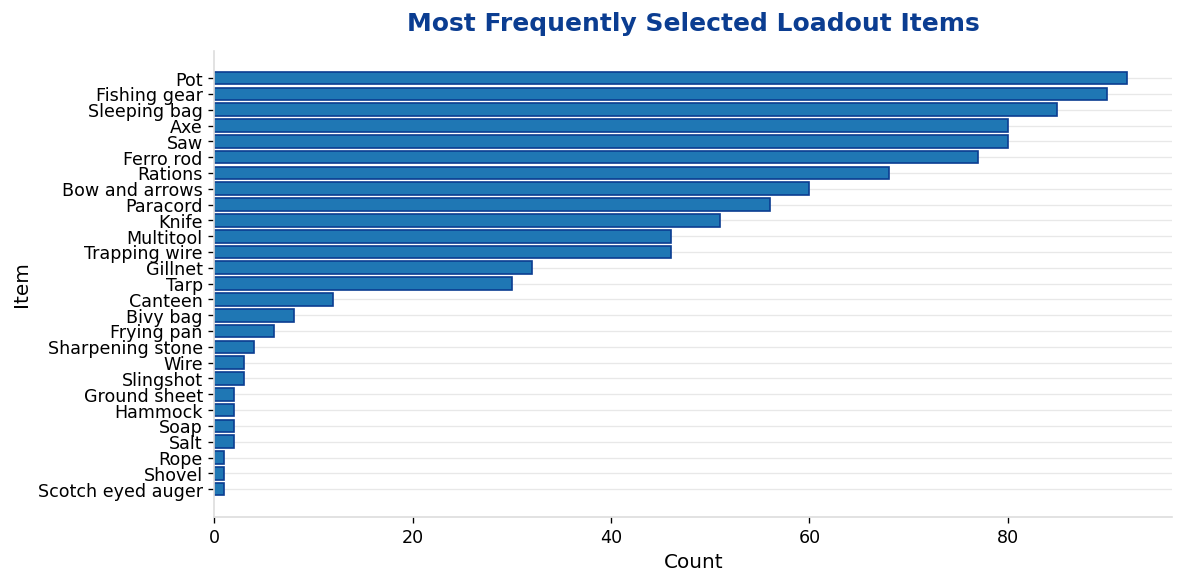

In [17]:
top_items = item_counts

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(
    top_items.index[::-1],
    top_items["count"][::-1],
    color=BLUE,
    edgecolor=BLUE_DARK
)

polish_ax(
    ax,
    title="Most Frequently Selected Loadout Items",
    xlabel="Count",
    ylabel="Item"
)

plt.tight_layout()
plt.show()


**EDA Insights — Most Frequently Selected Loadout Items**

- A small set of core items is selected by most participants, while many other items appear far less frequently. This indicates that individual items alone are insufficient to define strategies, as common items provide limited discriminatory power across participants.

##EDA 2 — Survival Outcomes

- We begin with the primary outcome: days_lasted, which captures how long each participant remained in the competition.

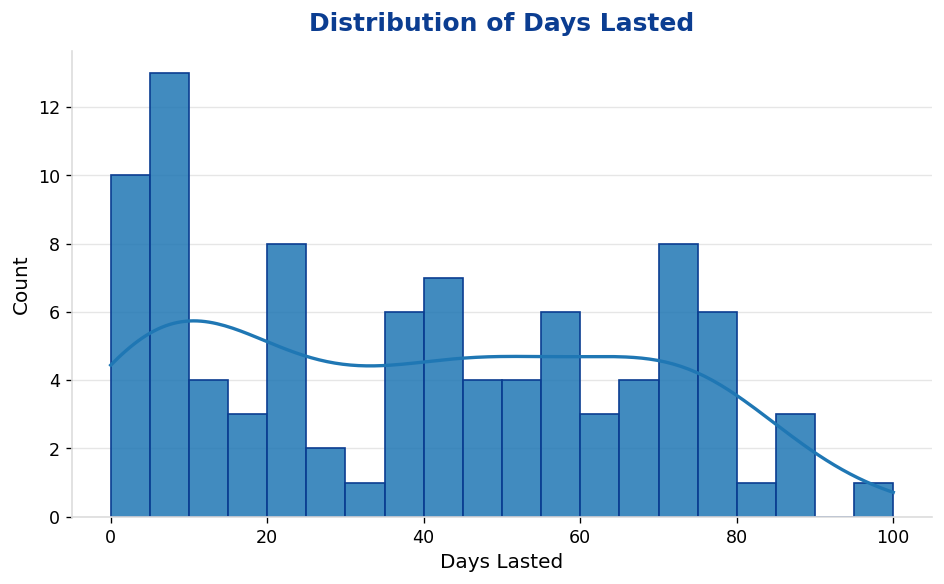

In [18]:
plt.figure(figsize=(8, 5), dpi=120)

sns.histplot(
    survivalists["days_lasted"].dropna(),
    bins=20,
    kde=True,
    color=BLUE,
    edgecolor=BLUE_DARK,
    alpha=0.85,
    line_kws={
        "color": BLUE_DARK,
        "linewidth": 2
    }
)

plt.title(
    "Distribution of Days Lasted",
    fontsize=15,
    fontweight="bold",
    color=BLUE_DARK,
    pad=12
)
plt.xlabel("Days Lasted", fontsize=12)
plt.ylabel("Count", fontsize=12)


ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


ax.grid(True, axis="y", color=GRID, linewidth=0.8)
ax.grid(False, axis="x")

plt.tight_layout()
plt.show()

**EDA Insights — Distribution of Days Lasted**

- Survival duration exhibits substantial variability and a right-skewed distribution, without clear multimodal separation. This suggests that survival outcomes alone do not naturally partition participants into distinct groups, motivating an upstream focus on strategy discovery rather than outcome-based grouping.

In [19]:
item_counts = (
    loadouts["item"]
    .value_counts()
    .sort_values(ascending=False)
)

item_counts.head(10)

,count
item,
Pot,92
Fishing gear,90
Sleeping bag,85
Axe,80
Saw,80
Ferro rod,77
Rations,68
Bow and arrows,60
Paracord,56


In [20]:
low_freq_threshold = 5
num_low_freq_items = (item_counts <= low_freq_threshold).sum()
total_items = item_counts.shape[0]

print(f"Items appearing ≤ {low_freq_threshold} times: {num_low_freq_items}/{total_items}")
print(f"Percentage of low-frequency items: {num_low_freq_items / total_items:.2%}")

Items appearing ≤ 5 times: 10/27
Percentage of low-frequency items: 37.04%


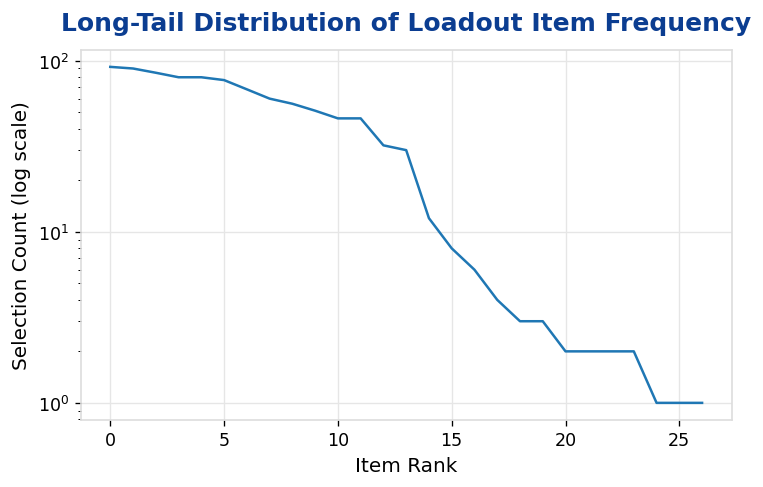

In [21]:
plt.figure(figsize=(7,4))
plt.plot(item_counts.values)
plt.yscale("log")
plt.xlabel("Item Rank")
plt.ylabel("Selection Count (log scale)")
plt.title("Long-Tail Distribution of Loadout Item Frequency",fontsize=15,
    fontweight="bold",
    color=BLUE_DARK,
    pad=12)
plt.show()

**EDA Insights — Long-Tail Distribution of Loadout Item Frequency**
- Loadout item usage follows a pronounced long-tail distribution, with a majority of items appearing only a handful of times. This sparse, high-dimensional feature space makes a priori strategy definitions difficult and motivates unsupervised methods to uncover latent structure.

In [22]:
#pairwise Jaccard similarity
def jaccard_similarity(a: set, b: set) -> float:
    if not a and not b:
        return 1.0
    return len(a & b) / len(a | b)

similarities = []

for (_, p1), (_, p2) in combinations(participant_items.iterrows(), 2):
    sim = jaccard_similarity(p1["item"], p2["item"])
    similarities.append(sim)

similarities = pd.Series(similarities)
similarities.describe()

,0
count,4371.000000
mean,0.544444
std,0.159342
min,0.125000
25%,0.428571
50%,0.538462
75%,0.666667
max,1.000000


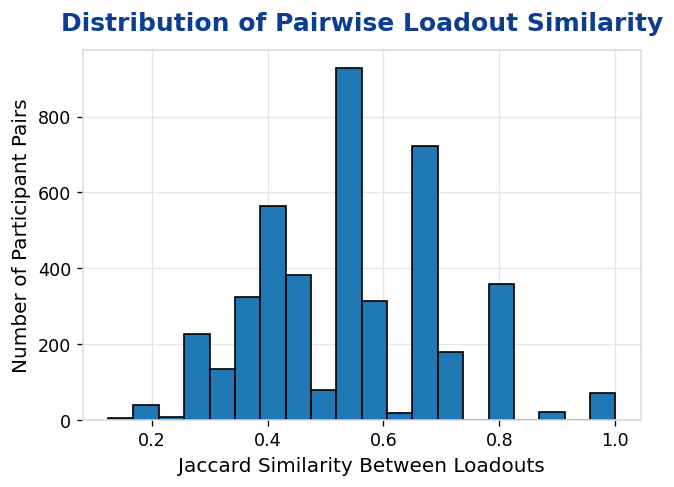

In [23]:
plt.figure(figsize=(6,4))
plt.hist(similarities, bins=20, edgecolor="black")
plt.xlabel("Jaccard Similarity Between Loadouts")
plt.ylabel("Number of Participant Pairs")
plt.title("Distribution of Pairwise Loadout Similarity",fontsize=15,
    fontweight="bold",
    color=BLUE_DARK,
    pad=12)
plt.show()

**EDA Insights — Distribution of Pairwise Loadout Similarity**
- Pairwise Jaccard similarity between loadouts shows substantial overlap among some participants, while remaining broadly dispersed across the sample. This suggests the presence of partial shared strategy patterns rather than a small number of dominant templates, consistent with heterogeneous and implicitly defined survival strategies.

# Analysis & Experiments —— Jaccard + Hierarchical Clustering

In [24]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [25]:
loadouts = loadouts.copy()
survivalists = survivalists.copy()

for col in ["name"]:
    loadouts[col] = loadouts[col].astype(str).str.strip()
    survivalists[col] = survivalists[col].astype(str).str.strip()

loadouts["item"] = loadouts["item"].astype(str).str.strip()

loadouts["pid"] = loadouts["season"].astype(str) + " | " + loadouts["name"]
survivalists["pid"] = survivalists["season"].astype(str) + " | " + survivalists["name"]

In [26]:
participant_items = (
    loadouts.groupby("pid")["item"]
    .apply(lambda x: set(x.dropna()))
    .reset_index(name="item_set")
)

participant_items["num_unique_items"] = participant_items["item_set"].apply(len)

df = participant_items.merge(
    survivalists[["pid", "season", "name", "days_lasted", "result", "medically_evacuated", "reason_category"]],
    on="pid",
    how="left"
)

df["num_unique_items"].value_counts().sort_index(ascending=False)

,count
num_unique_items,
10,72
9,16
8,4
7,2


In [27]:
df = df.sort_values("pid").reset_index(drop=True)
item_sets = df["item_set"].tolist()
pids = df["pid"].tolist()
n = len(item_sets)

S = np.eye(n)
for i in range(n):
    for j in range(i+1, n):
        sim = jaccard_similarity(item_sets[i], item_sets[j])
        S[i, j] = sim
        S[j, i] = sim

# Distance matrix
D = 1 - S

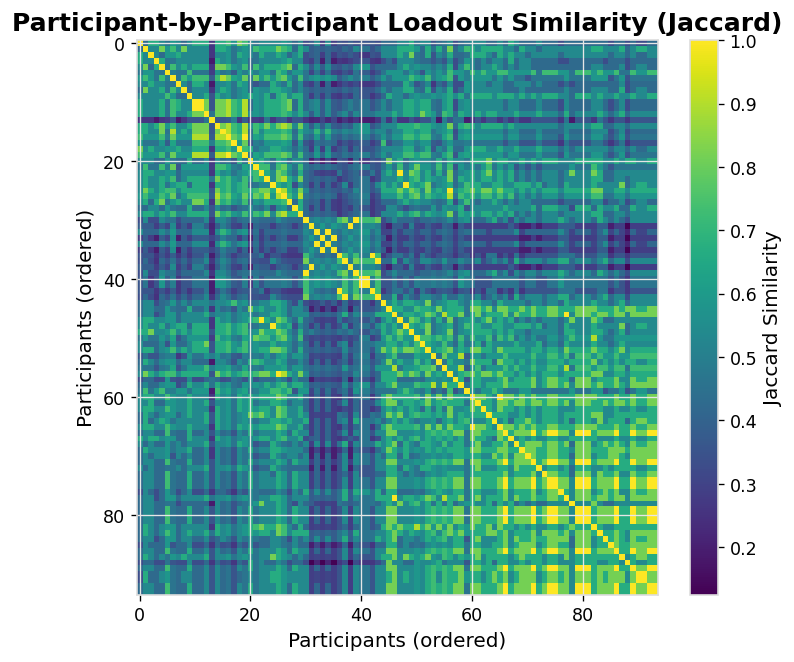

In [28]:
plt.figure(figsize=(7,6))
plt.imshow(S, aspect="auto")
plt.colorbar(label="Jaccard Similarity")
plt.title("Participant-by-Participant Loadout Similarity (Jaccard)")
plt.xlabel("Participants (ordered)")
plt.ylabel("Participants (ordered)")
plt.show()

This heatmap shows generally high pairwise similarity across participants, with no clear block structures. This suggests that most contestants select highly overlapping loadouts, limiting the emergence of strongly differentiated strategy groups.

In [37]:
condensed_D = squareform(D, checks=False)
Z_avg = linkage(condensed_D, method="average")
Z_comp = linkage(condensed_D, method="complete")

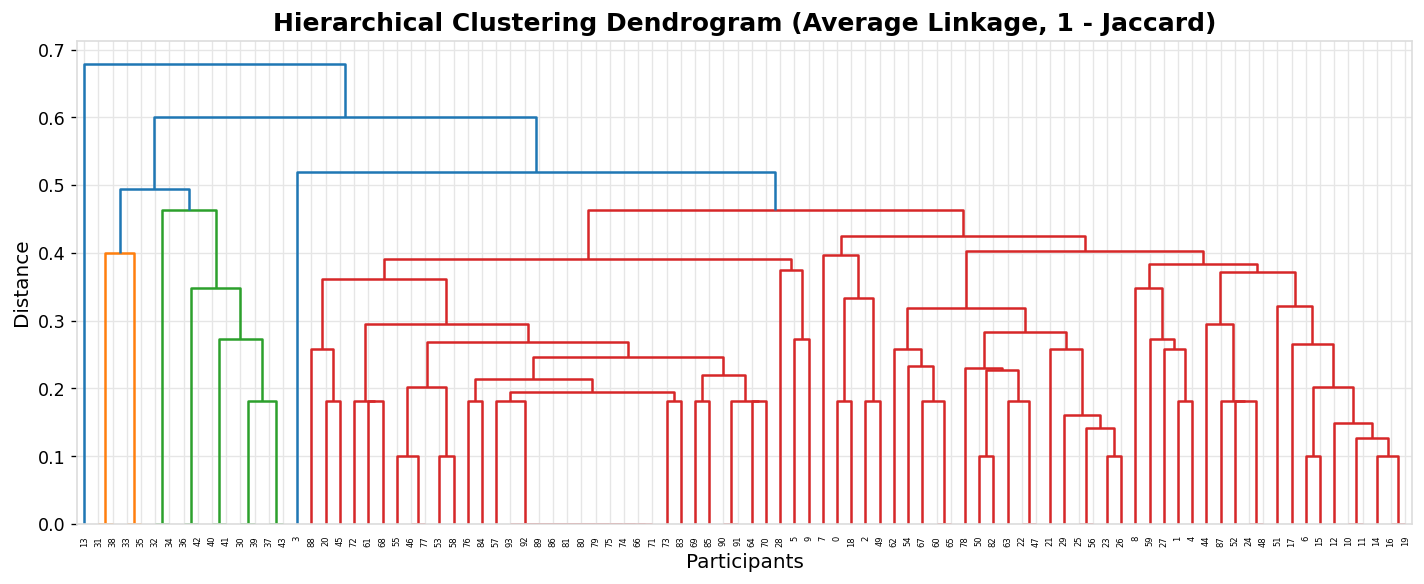

In [30]:
plt.figure(figsize=(12,5))
dendrogram(Z_avg, labels=None, color_threshold=None)
plt.title("Hierarchical Clustering Dendrogram (Average Linkage, 1 - Jaccard)")
plt.xlabel("Participants")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

The dendrogram reveals gradual merging rather than sharp separation between groups, indicating weak natural cluster boundaries. Cluster cuts at different heights primarily reflect analytical choices rather than distinct underlying strategy types.

In [31]:
k = 3  # have tried 2/3/4/5
cluster_labels_k = fcluster(Z_avg, t=k, criterion="maxclust")
df[f"cluster_k{k}"] = cluster_labels_k
df[f"cluster_k{k}"].value_counts().sort_index()

,count
cluster_k3,
1,14
2,79
3,1


In [32]:
#compare average vs complete linkage cluster sizes
for method, Z in [("average", Z_avg), ("complete", Z_comp)]:
    labs = fcluster(Z, t=k, criterion="maxclust")
    counts = pd.Series(labs).value_counts().sort_index()
    print(f"\nMethod={method}, k={k}\n{counts}")


Method=average, k=3
1    14
2    79
3     1
Name: count, dtype: int64

Method=complete, k=3
1    77
2     3
3    14
Name: count, dtype: int64


- Loadout configurations do not give rise to a large number of discrete strategy types(k).
At most, the data supports one dominant configuration family and one smaller, partially distinct subgroup, with additional variation occurring at the individual level rather than forming stable clusters.


In [33]:
def cluster_item_profile(df_in: pd.DataFrame, cluster_col: str, top_n: int = 8):
    rows = []
    for c, sub in df_in.groupby(cluster_col):
        members = sub["item_set"].tolist()
        m = len(members)
        item_counts = {}
        for s in members:
            for it in s:
                item_counts[it] = item_counts.get(it, 0) + 1
        prof = pd.Series(item_counts).sort_values(ascending=False)
        prof_pct = (prof / m).head(top_n)
        for it, pct in prof_pct.items():
            rows.append({"cluster": c, "item": it, "pct_members": pct, "n_members": m})
    return pd.DataFrame(rows)

cluster_col = f"cluster_k{k}"
profile = cluster_item_profile(df, cluster_col=cluster_col, top_n=10)
profile.sort_values(["cluster", "pct_members"], ascending=[True, False]).head(30)

,cluster,item,pct_members,n_members
0,1,Tarp,1.000000,14
1,1,Fishing gear,1.000000,14
2,1,Pot,1.000000,14
3,1,Saw,1.000000,14
4,1,Axe,0.857143,14
5,1,Rations,0.857143,14
6,1,Gillnet,0.714286,14
7,1,Multitool,0.428571,14
8,1,Bow and arrows,0.428571,14
9,1,Paracord,0.285714,14


Across clusters, high-prevalence items are largely shared, while differences arise mainly from the relative frequency of secondary tools. This reinforces the interpretation that clusters differ by emphasis rather than by fundamentally distinct loadout strategies.

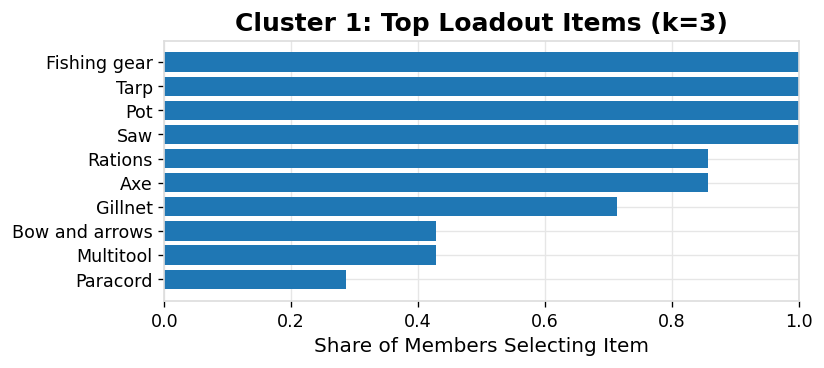

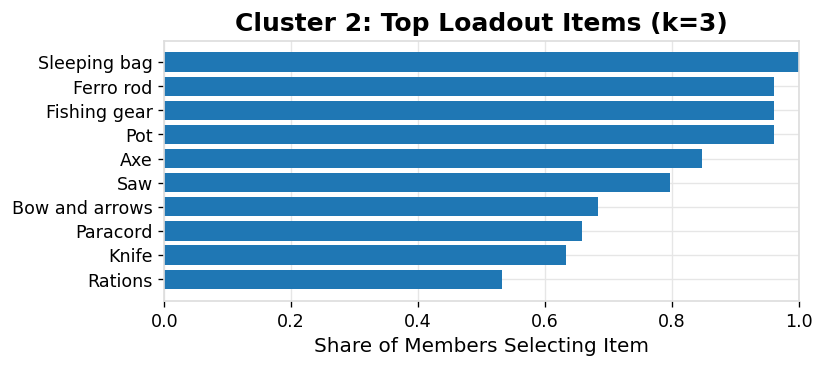

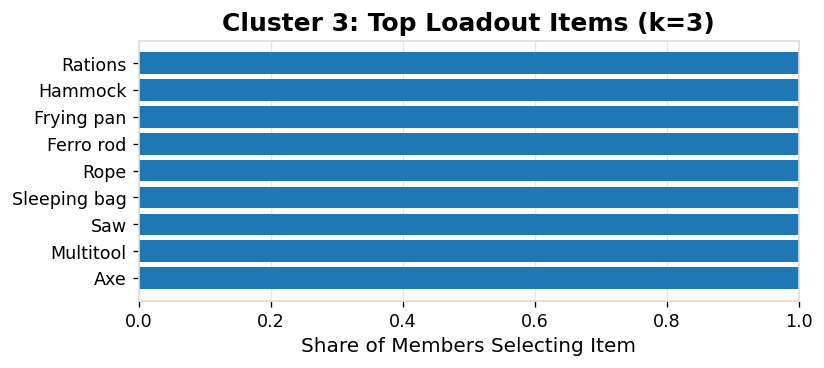

In [34]:
# Plot top items per cluster (simple small multiples)
clusters = sorted(df[cluster_col].unique())
for c in clusters:
    sub = profile[profile["cluster"] == c].sort_values("pct_members", ascending=True)
    plt.figure(figsize=(7,3.2))
    plt.barh(sub["item"], sub["pct_members"])
    plt.xlabel("Share of Members Selecting Item")
    plt.title(f"Cluster {c}: Top Loadout Items (k={k})")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

- Cluster 1 is characterized by near-universal selection of core tools such as fishing gear, tarp, pot, and saw, with moderate variation in secondary items. This profile reflects a broadly generalist survival approach rather than a specialized strategy.
- Cluster 2 represents the majority of participants and closely mirrors the overall population’s loadout composition. The dominance of this cluster highlights strong convergence in preparation choices driven by shared survival constraints.
- Cluster 3 consists of a singleton participant with a unique combination of secondary items. This cluster reflects individual deviation rather than a reproducible or generalizable strategy type.

In [35]:
summary = (
    df.groupby(cluster_col)
      .agg(n=("pid", "count"),
           days_mean=("days_lasted", "mean"),
           days_median=("days_lasted", "median"),
           days_std=("days_lasted", "std"))
      .sort_values("n", ascending=False)
)
summary

,n,days_mean,days_median,days_std
cluster_k3,,,,
2,79,40.443038,41.0,27.155651
1,14,31.428571,14.0,32.376901
3,1,35.000000,35.0,NaN


*  **Overall, similarity-based clustering reveals limited evidence of discrete survival strategy types. While minor variations in loadout emphasis exist, the strong overlap in core items constrains strategic differentiation and weakens the link between initial preparation and survival outcomes.**

/tmp/ipython-input-2615075058.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(c) for c in clusters], showfliers=False)


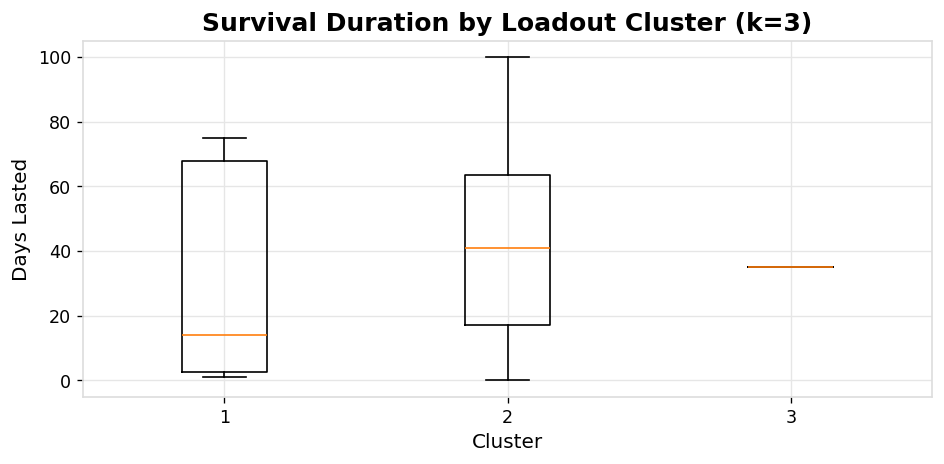

In [36]:
clusters = sorted(df[cluster_col].unique())
data = [df.loc[df[cluster_col]==c, "days_lasted"].dropna().values for c in clusters]

plt.figure(figsize=(8,4))
plt.boxplot(data, labels=[str(c) for c in clusters], showfliers=False)
plt.xlabel("Cluster")
plt.ylabel("Days Lasted")
plt.title(f"Survival Duration by Loadout Cluster (k={k})")
plt.tight_layout()
plt.show()

Survival duration distributions overlap substantially across clusters, with no clear monotonic relationship between cluster membership and survival outcomes. This suggests that initial loadout configuration alone has limited explanatory power for long-term survival.

##Summary

- This analysis examined whether participants’ initial loadout configurations give rise to distinct, implicit survival strategy types. Using Jaccard similarity and hierarchical clustering, we found that loadout choices exhibit substantial overlap across participants, with only weak and unstable cluster structure. Across multiple values of k, clustering consistently produced one dominant group, a smaller secondary group, and a small number of idiosyncratic outliers, rather than clearly separated strategy types.

- Further inspection of cluster item profiles showed that differences between groups are driven primarily by variation in secondary items, while core survival tools are shared by nearly all participants. Importantly, survival duration distributions overlap substantially across clusters, suggesting that initial loadout configuration alone has limited explanatory power for survival outcomes. Together, these results indicate that survival strategies in Alone are not well-captured by static preparation choices, pointing instead toward the importance of in-season decision-making and dynamic adaptation.